# OB161195 Analysis

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import pickle
import emcee
import time as ti
from tqdm import tqdm
import os
from multiprocessing import Pool
import corner
from scipy import optimize as opt
import random

from Spitzer_ulens import data_config
from Spitzer_ulens import models
from Spitzer_ulens import PLD

## Configuration and Preparation

This section demonstrates usage of the 'data_config' module.

In [2]:
coords = ('17:55:23.50','-30:12:26.1')
data_path = 'data/ob161195/rawdata/'
ogle_data_file = 'data/ob161195/ob161195_ogle.dat'

In [3]:
load_evt_from_file = True
if load_evt_from_file:
    fname = 'ob161195.pkl'
    with open(fname,'rb') as file:
        evt = pickle.load(file)
else:
    # Create a PLDEventData object from our data
    evt = data_config.PLDEventData(data_path,coords,recursive=True)
    evt.add_OGLE_data(ogle_data_file)
    # Save our PLDEventData object
    evt.save(filepath='ob161195.pkl',overwrite=True)

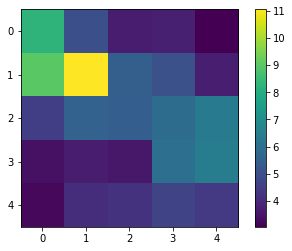

In [4]:
# Plotting an example of a 5-by-5 image
fig,ax = plt.subplots()
im = ax.imshow(evt.img[5][10])
fig.colorbar(im)
plt.show()

Text(0.5, 1.0, 'Spitzer Data')

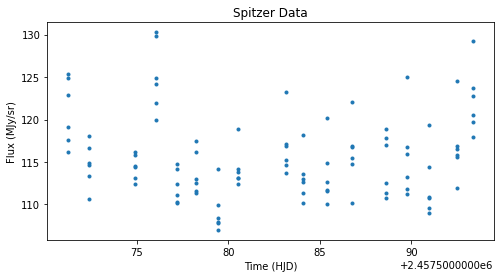

In [5]:
# Get raw photometry, error, and binned error
flux,flux_err,flux_frac,flux_scatter = evt.aperture_photometry()
time = np.array(evt.time)
ind = time<2457700
time = (time[ind]).reshape(6,-1)
flux = flux[ind].reshape(6,-1)
flux_err = flux_err[ind].reshape(6,-1)
flux_frac = flux_frac[ind].reshape(6,-1,5,5)

# Plot our raw data
fig,ax = plt.subplots(figsize=(8,4))

ax.plot(time.ravel(),flux.ravel(),'C0.')
ax.set_xlabel('Time (HJD)')
ax.set_ylabel('Flux (MJy/sr)')
ax.set_title('Spitzer Data')

## Creating a model to fix t_0 as reported by Shvartzvald et al

In [6]:
class SingleLensFixedt0Model(models.LCModel):
    def __init__(self,t0):
        self.t0 = t0
    
    def func(self,time,tE,fb,fs):
        ts = (time-self.t0)/(tE/np.sqrt(12))
        flux = fb+fs/(np.sqrt(ts**2 +1))
        return flux

In [7]:
model = SingleLensFixedt0Model(2457573.5)

## Least-Squares Fit

In this section we do a least-squares fit to obtain some better parameter estimates. These will eventually become initial parameters for the MCMC fit. In this section we introduce the 'models' module.

In [8]:
# Make an initial guess for model parameters, which will be used as starting point for the least-squares fit.

# Single lens model:
tE = 14.79             # Einstein radius crossing time
fs = 19.7              # Space-based source flux
fb = 82                # Space-based baseline flux

p0 = np.array([tE,fb,fs])

# Specify some (loose) bounds on our parameters.
bounds = ([0,0,0],[140,np.inf,np.inf])

# Labels for printing later
plabels = ['t_E','f_b','f_s']

Text(0.5, 1.0, 'Spitzer Data Fit')

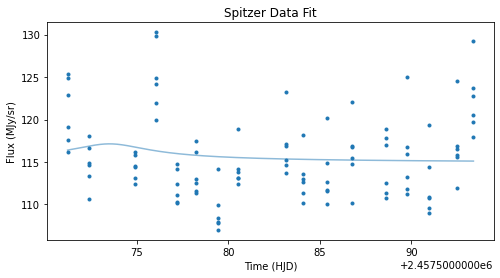

In [9]:
popt_lsq,cov = opt.curve_fit(model,time.ravel(),flux.ravel(),p0,bounds=bounds)

timeplot = np.linspace(np.min(time),np.max(time),1000)

fig,ax = plt.subplots(figsize=(8,4))

ax.plot(timeplot,model(timeplot,*popt_lsq),'C0',alpha=0.5)
ax.plot(time.ravel(),flux.ravel(),'C0.')
ax.set_xlabel('Time (HJD)')
ax.set_ylabel('Flux (MJy/sr)')
ax.set_title('Spitzer Data Fit')

## Solving PLD Coefficients Analytically

In [10]:
# Solve for PLD coefficients analytically (X)
astro, pld_coeffs, A, C = PLD.analytic_solution(time,flux,flux_err,flux_frac,popt_lsq,model)
# Get detector model and divide it out to get new best-fit
fit,sys,corr,resi = PLD.get_bestfit(pld_coeffs, flux, flux_frac, astro, A)

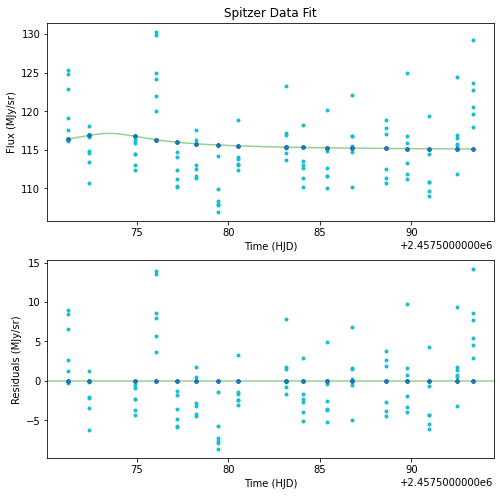

In [11]:
def plot_analytic_sol(model,time,popt,astro,flux,corr):
    timeplot = np.linspace(np.min(time),np.max(time),1000)

    fig,ax = plt.subplots(nrows=2,figsize=(8,8))

    ax[0].plot(timeplot,model(timeplot,*popt),'C2',alpha=0.5)
    ax[0].plot(time.ravel(),flux.ravel(),'C9.')
    ax[0].plot(time.ravel(),corr.ravel(),'C0.')
    ax[0].set_xlabel('Time (HJD)')
    ax[0].set_ylabel('Flux (MJy/sr)')
    ax[0].set_title('Spitzer Data Fit')

    ax[1].axhline(c='C2',alpha=0.5)
    ax[1].plot(time.ravel(),flux.ravel()-astro.ravel(),'C9.')
    ax[1].plot(time.ravel(),corr.ravel()-astro.ravel(),'C0.')
    ax[1].set_xlabel('Time (HJD)')
    ax[1].set_ylabel('Residuals (MJy/sr)')
    
plot_analytic_sol(model,time,popt_lsq,astro,flux,corr)

In [12]:
print(p0)
print(popt_lsq)

[14.79 82.   19.7 ]
[  7.28173846 114.86676      2.26773541]


## MCMC Fit for PLD Parameters

In this section we run a Markov Chain Monte-Carlo (MCMC) fit to our data. This will explore parameter space to optimize the log-likelihood for our model to fit our data. We use the emcee package (https://github.com/dfm/emcee) to do our fit. The log-likelihood function we use is a method of the SingleLensParallaxModel class, as detailed in the 'Spitzer_ulens.models' module.

In [13]:
def run_mcmc(sampler,pos0,nsteps,visual=True,label=''):
    if visual:
        tic = ti.time()
        print('Running MCMC '+label+'...')
        
        # Using tqdm package to generate progress bars
        for pos, prob, state in tqdm(sampler.sample(pos0, iterations=nsteps),total=nsteps):
            pass

        print("Mean burn-in acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
        toc = ti.time()
        print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))
        return pos,prob,state
    else:
        pos,prob,state = sampler.run_mcmc(pos0,nsteps)
        return pos,prob,state

In [14]:
def get_MCMC_results(pos_chain,lnp_chain):
    _,_,npars = pos_chain.shape
    posit = pos_chain.reshape(-1,npars)

    # Get the percentile
    percs = np.percentile(posit, [16, 50, 84],axis=0)
    (MCMC_Results) = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*percs))))

    popt = MCMC_Results[:,0]
    std_hi = MCMC_Results[:,1]
    std_lo = MCMC_Results[:,2]

    # Get most probable params
    probs = lnp_chain.flatten()
    pmax = posit[np.argmax(probs)]
    
    return popt,pmax,std_hi,std_lo

In [15]:
load_chain_from_file = True
savepath = 'data/ob161195/mcmc/schvartzvald'

if load_chain_from_file:
    pos_chain = np.load(os.path.join(savepath,'samplerchain.npy'))
    lnp_chain = np.load(os.path.join(savepath,'samplerlnpro.npy'))
else:
    p0 = popt_lsq
    nwalkers = 100
    nburnin = 300
    nprod = 1000
    
    # Generate the MCMC sampler with 100 walkers, our log-probability function, and our data. We
    # use pool from the multiprocessing package to parallelize the process.
    sampler = emcee.EnsembleSampler(nwalkers, len(p0), model.lnprob, a = 2,
                                    args=(bounds,time,flux,flux_err,flux_frac,
                                          flux_scatter))
    
    # Initialize the initial parameter positions for each walker by adding a random offset. Starting
    # our walkers in different positions allows us to explore more parameter space.
    pos0 = [p0*(1+1e-5*np.random.randn(sampler.ndim))+1e-5*np.abs(np.random.randn(sampler.ndim)) 
            for i in range(sampler.nwalkers)]
    
    # Run the first MCMC burn-in.
    pos1,prob,state = run_mcmc(sampler,pos0,nburnin,label='first burn-in')
    sampler.reset()

    #Run the MCMC from best spot from last time, and do another burn-in to get the walkers spread out.
    pos2 = pos1[np.argmax(prob)]
    
    # Slightly change position of walkers to prevent them from taking the same path
    pos2 = [pos2*(1+1e-6*np.random.randn(sampler.ndim))+1e-6*np.abs(np.random.randn(sampler.ndim)) 
            for i in range(sampler.nwalkers)]
    
    # Run the second burn-in
    pos2, prob, state = run_mcmc(sampler,pos2,nburnin,label='second burn-in')
    sampler.reset()
    
    #Run the final production run that will be saved
    pos_final, prob, state = run_mcmc(sampler,pos2,nprod,label='production')

    pos_chain = sampler.chain
    lnp_chain = sampler.lnprobability
    
    np.save(savepath+'/samplerchain.npy',pos_chain)
    np.save(savepath+'/samplerlnpro.npy',lnp_chain)
    
# Get results from chain
popt_mcmc,pmax,std_hi,std_lo = get_MCMC_results(pos_chain,lnp_chain)

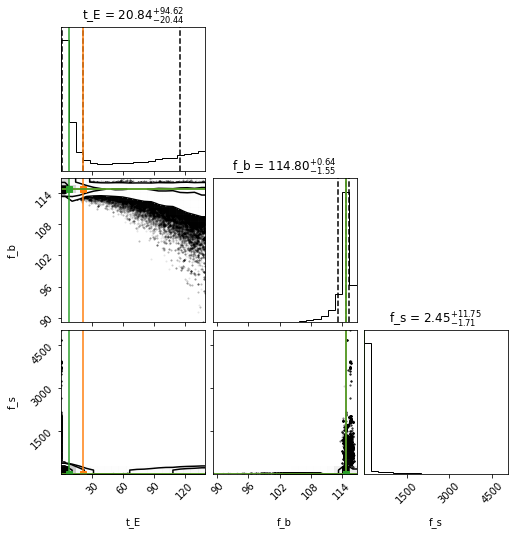

In [16]:
# Create corner plots to check for convergence
# 1d array of samples
samples = pos_chain.reshape((-1, len(popt_mcmc)))

# corner plot
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, plot_datapoints=True, 
                    title_kwargs={"fontsize": 12},labels=plabels)

corner.overplot_lines(fig, popt_mcmc, color="C1", label='Mean parameter position')
corner.overplot_points(fig, popt_mcmc[None], marker="s", color="C1")
corner.overplot_lines(fig, pmax, color="C2", label='Most likely parameter position')
corner.overplot_points(fig, pmax[None], marker="s", color="C2")

#plt.legend(loc=(-5,7),fontsize=16)

In [ ]:
# Re-run MCMC if it does not look converged. This cell can be run repeatedly.
rerun_mcmc = True
if rerun_mcmc:
    nwalkers = 100
    nprod = 3000
    
    sampler = emcee.EnsembleSampler(nwalkers, len(p0), model.lnprob, a = 2,
                                    args=(bounds,time,flux,flux_err,flux_frac,
                                          flux_scatter))
    pos0 = pos_chain[:,-1,:]

    pos_final,prob_final,state_final = run_mcmc(sampler,pos0,nprod,label='production')

    pos_chain = sampler.chain
    lnp_chain = sampler.lnprobability
    
    popt_mcmc,pmax,std_hi,std_lo = get_MCMC_results(pos_chain,lnp_chain)
    
    np.save(savepath+'/samplerchain.npy',pos_chain)
    np.save(savepath+'/samplerlnpro.npy',lnp_chain)

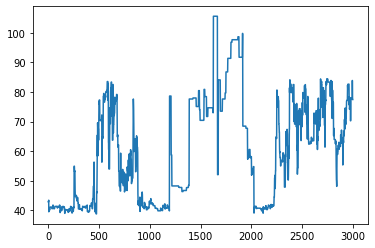

In [19]:
plt.plot(np.mean(pos_chain,axis=2)[1,:])

In [20]:
# Reporting best-fit parameters
def pretty_print(popt,pmax,std_hi,std_lo,labels):
    tab = np.transpose([labels,popt,pmax,std_hi,std_lo])
    print('\t%s\t\t%s\t%s\t\t%s'%('Mean Parameter','Most Likely Parameter',r'Upper 1 sigma',r'Lower 1 sigma'))
    for row in tab:
        print('%s\t%s\t%s\t%s\t%s'%(row[0],row[1],row[2],row[3],row[4]))
pretty_print(popt_mcmc,pmax,std_hi,std_lo,plabels)

	Mean Parameter		Most Likely Parameter	Upper 1 sigma		Lower 1 sigma
t_E	20.83756850457307	7.25845554225109	94.62469257223316	20.441437466434852
f_b	114.79683819942927	114.85946282624236	0.6370609752835037	1.5459765097716769
f_s	2.4539980286471783	2.288971276708409	11.750066515060396	1.7115330367159058


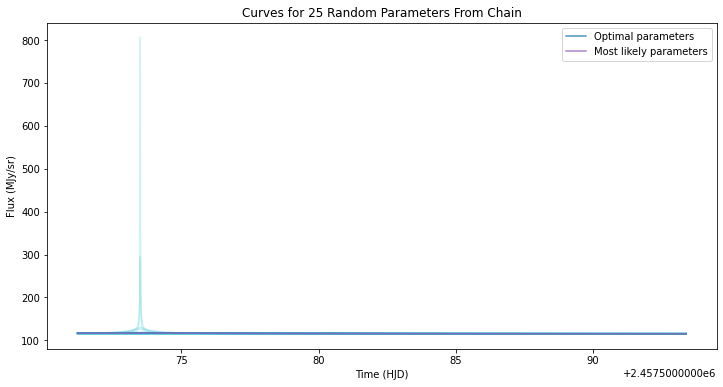

In [21]:
def plot_random_curves(pos_chain,model,timeplot,popt=None,pmax=None,ncurves=1,seed=None,figsize=(8,4)):
    fig,ax = plt.subplots(figsize=figsize)
    nwalkers,nsteps,npars = np.shape(pos_chain)
    chain = pos_chain.reshape(nwalkers*nsteps,-1)
    for i in range(ncurves):
        pars = random.choice(chain)
        ax.plot(timeplot,model(timeplot,*pars),alpha=0.2,c='C9')
    ax.set_title('Curves for %i Random Parameters From Chain'%ncurves)
    ax.set_xlabel('Time (HJD)')
    ax.set_ylabel('Flux (MJy/sr)')
    if popt is not None:
        ax.plot(timeplot,model(timeplot,*popt),alpha=0.8,c='C0',label='Optimal parameters')
    if pmax is not None:
        ax.plot(timeplot,model(timeplot,*pmax),alpha=0.8,c='C4',label='Most likely parameters')
    ax.legend()
        
plot_random_curves(pos_chain,model,timeplot,popt=popt_mcmc,pmax=pmax,ncurves=25,figsize=(12,6))

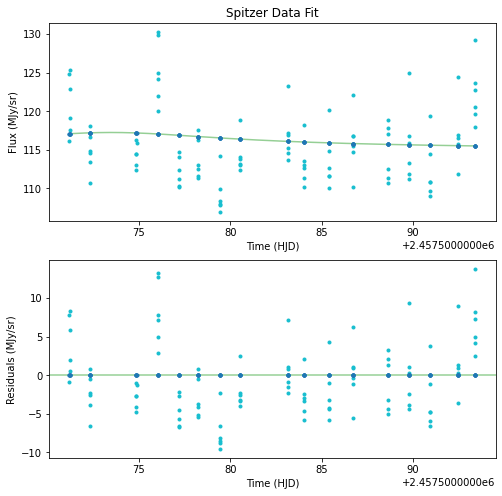

In [22]:
# Final analytic solution for corrected data
astro, pld_coeffs, A, C = PLD.analytic_solution(time,flux,flux_err,flux_frac,popt_mcmc,model)
# Get detector model and divide it out to get new best-fit
fit,sys,corr,resi = PLD.get_bestfit(pld_coeffs, flux, flux_frac, astro, A)
plot_analytic_sol(model,time,popt_mcmc,astro,flux,corr)

## Defining some ways for comparing models

In [23]:
def get_BIC():
    pass

# Fitting a flat line

In [24]:
class FlatLineModel(models.LCModel):
    def func(self,time,fb):
        return time*0+fb
    
model = FlatLineModel()

In [25]:
# Make an initial guess for model parameters, which will be used as starting point for the least-squares fit.

# Single lens model:
fb = 115

p0 = np.array([fb])

# Specify some (loose) bounds on our parameters.
bounds = ([0],[140])

# Labels for printing later
plabels = ['f_b']

Text(0.5, 1.0, 'Spitzer Data Fit')

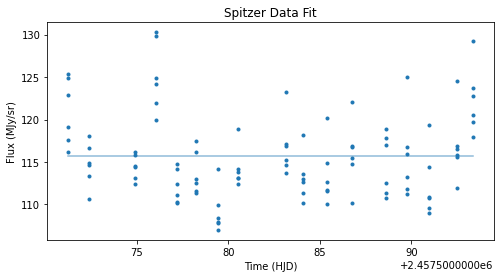

In [26]:
popt_lsq,cov = opt.curve_fit(model,time.ravel(),flux.ravel(),p0,bounds=bounds)

timeplot = np.linspace(np.min(time),np.max(time),1000)

fig,ax = plt.subplots(figsize=(8,4))

ax.plot(timeplot,model(timeplot,*popt_lsq),'C0',alpha=0.5)
ax.plot(time.ravel(),flux.ravel(),'C0.')
ax.set_xlabel('Time (HJD)')
ax.set_ylabel('Flux (MJy/sr)')
ax.set_title('Spitzer Data Fit')

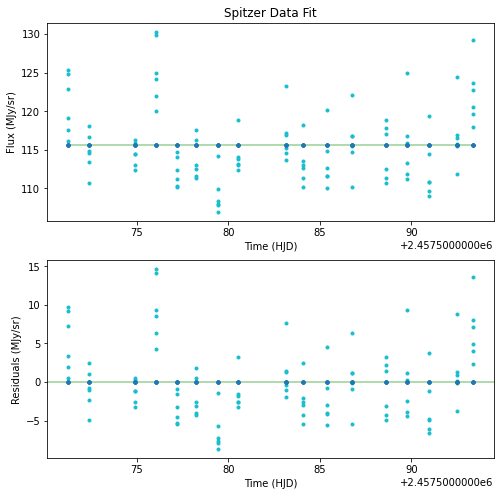

In [27]:
# Solve for PLD coefficients analytically (X)
astro, pld_coeffs, A, C = PLD.analytic_solution(time,flux,flux_err,flux_frac,popt_lsq,model)
# Get detector model and divide it out to get new best-fit
fit,sys,corr,resi = PLD.get_bestfit(pld_coeffs, flux, flux_frac, astro, A)
plot_analytic_sol(model,time,popt_lsq,astro,flux,corr)

In [28]:
load_chain_from_file = True
savepath = 'data/ob161195/mcmc/flatline'

if load_chain_from_file:
    pos_chain = np.load(os.path.join(savepath,'samplerchain.npy'))
    lnp_chain = np.load(os.path.join(savepath,'samplerlnpro.npy'))
else:
    p0 = popt_lsq
    nwalkers = 100
    nburnin = 300
    nprod = 1000
    
    # Generate the MCMC sampler with 100 walkers, our log-probability function, and our data. We
    # use pool from the multiprocessing package to parallelize the process.
    sampler = emcee.EnsembleSampler(nwalkers, len(p0), model.lnprob, a = 2,
                                    args=(bounds,time,flux,flux_err,flux_frac,
                                          flux_scatter))
    
    # Initialize the initial parameter positions for each walker by adding a random offset. Starting
    # our walkers in different positions allows us to explore more parameter space.
    pos0 = [p0*(1+1e-5*np.random.randn(sampler.ndim))+1e-5*np.abs(np.random.randn(sampler.ndim)) 
            for i in range(sampler.nwalkers)]
    
    # Run the first MCMC burn-in.
    pos1,prob,state = run_mcmc(sampler,pos0,nburnin,label='first burn-in')
    sampler.reset()

    #Run the MCMC from best spot from last time, and do another burn-in to get the walkers spread out.
    pos2 = pos1[np.argmax(prob)]
    
    # Slightly change position of walkers to prevent them from taking the same path
    pos2 = [pos2*(1+1e-6*np.random.randn(sampler.ndim))+1e-6*np.abs(np.random.randn(sampler.ndim)) 
            for i in range(sampler.nwalkers)]
    
    # Run the second burn-in
    pos2, prob, state = run_mcmc(sampler,pos2,nburnin,label='second burn-in')
    sampler.reset()
    
    #Run the final production run that will be saved
    pos_final, prob, state = run_mcmc(sampler,pos2,nprod,label='production')

    pos_chain = sampler.chain
    lnp_chain = sampler.lnprobability
    
    np.save(savepath+'/samplerchain.npy',pos_chain)
    np.save(savepath+'/samplerlnpro.npy',lnp_chain)
    
# Get results from chain
popt_mcmc,pmax,std_hi,std_lo = get_MCMC_results(pos_chain,lnp_chain)

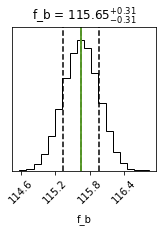

In [29]:
# Create corner plots to check for convergence
# 1d array of samples
samples = pos_chain.reshape((-1, len(popt_mcmc)))

# corner plot
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, plot_datapoints=True, 
                    title_kwargs={"fontsize": 12},labels=plabels)

corner.overplot_lines(fig, popt_mcmc, color="C1", label='Mean parameter position')
corner.overplot_points(fig, popt_mcmc[None], marker="s", color="C1")
corner.overplot_lines(fig, pmax, color="C2", label='Most likely parameter position')
corner.overplot_points(fig, pmax[None], marker="s", color="C2")

#plt.legend(loc=(-5,7),fontsize=16)

In [30]:
pretty_print(popt_mcmc,pmax,std_hi,std_lo,plabels)

	Mean Parameter		Most Likely Parameter	Upper 1 sigma		Lower 1 sigma
f_b	115.65255084087445	115.65232217214097	0.3117838467666161	0.3122627798515083


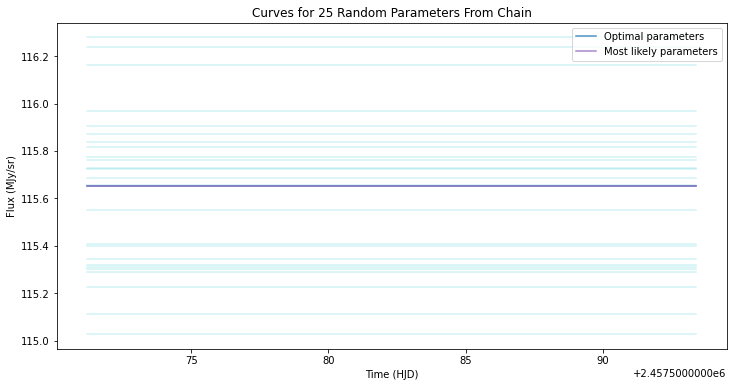

In [31]:
plot_random_curves(pos_chain,model,timeplot,popt=popt_mcmc,pmax=pmax,ncurves=25,figsize=(12,6))

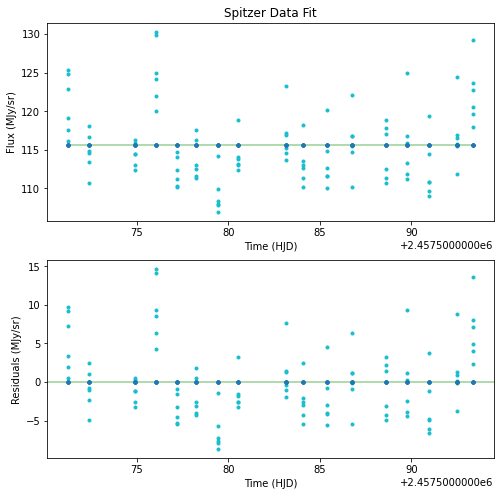

In [32]:
# Final analytic solution for corrected data
astro, pld_coeffs, A, C = PLD.analytic_solution(time,flux,flux_err,flux_frac,popt_mcmc,model)
# Get detector model and divide it out to get new best-fit
fit,sys,corr,resi = PLD.get_bestfit(pld_coeffs, flux, flux_frac, astro, A)
plot_analytic_sol(model,time,popt_mcmc,astro,flux,corr)

# Fixing t_0 using Keck's parallax measurements
## Obtaining t_0 from parallax measurements

In [33]:
keck_raw = np.loadtxt('data/ob161195/vandourou-ob161195_tobs_vs_magnif_spitz.txt',skiprows=1)
keck_full = np.loadtxt('data/ob161195/vandourou-spitzer_lc.txt',skiprows=1)

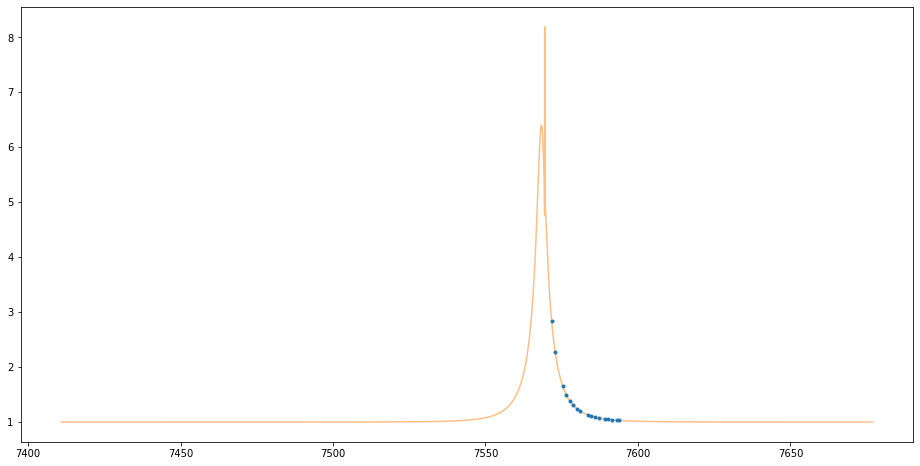

In [34]:
plt.figure(figsize=(16,8))
plt.plot(keck_full[2200:20000,0],keck_full[2200:20000,1],'C1',alpha=0.5)
plt.plot(keck_raw[:,0],keck_raw[:,1],'C0.')

In [35]:
pi_E_N = -0.04593
pi_E_E = 0.06834

## Get parameters from Keck data

In [36]:
indmax = np.argmax(keck_full[:,1])
keck_1lens = np.concatenate((keck_full[:indmax-70],keck_full[indmax+70:]))
tmax = keck_1lens[np.argmax(keck_1lens[:,1]),0]

7568.3276


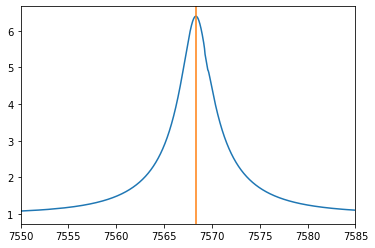

In [37]:
plt.plot(keck_1lens[:,0],keck_1lens[:,1])
plt.xlim(7550,7585)
plt.axvline(tmax,color='C1')
print(tmax)

## Use Keck t0 to fit the Spitzer data

## Least-Squares Fit

In this section we do a least-squares fit to obtain some better parameter estimates. These will eventually become initial parameters for the MCMC fit. In this section we introduce the 'models' module.

In [38]:
# Make an initial guess for model parameters, which will be used as starting point for the least-squares fit.

# Single lens model:
tE = 14.79             # Einstein radius crossing time
fs = 19.7              # Space-based source flux
fb = 82                # Space-based baseline flux

p0 = np.array([tE,fb,fs])

# Specify some (loose) bounds on our parameters.
bounds = ([0,0,0],[140,np.inf,np.inf])

# Labels for printing later
plabels = ['t_E','f_b','f_s']

Text(0.5, 1.0, 'Spitzer Data Fit')

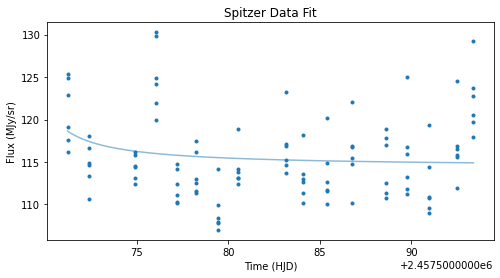

In [39]:
model = SingleLensFixedt0Model(2450000+tmax)

popt_lsq,cov = opt.curve_fit(model,time.ravel(),flux.ravel(),p0,bounds=bounds)

timeplot = np.linspace(np.min(time),np.max(time),1000)

fig,ax = plt.subplots(figsize=(8,4))

ax.plot(timeplot,model(timeplot,*popt_lsq),'C0',alpha=0.5)
ax.plot(time.ravel(),flux.ravel(),'C0.')
ax.set_xlabel('Time (HJD)')
ax.set_ylabel('Flux (MJy/sr)')
ax.set_title('Spitzer Data Fit')

## Solving PLD Coefficients Analytically

In [40]:
# Solve for PLD coefficients analytically (X)
astro, pld_coeffs, A, C = PLD.analytic_solution(time,flux,flux_err,flux_frac,popt_lsq,model)
# Get detector model and divide it out to get new best-fit
fit,sys,corr,resi = PLD.get_bestfit(pld_coeffs, flux, flux_frac, astro, A)

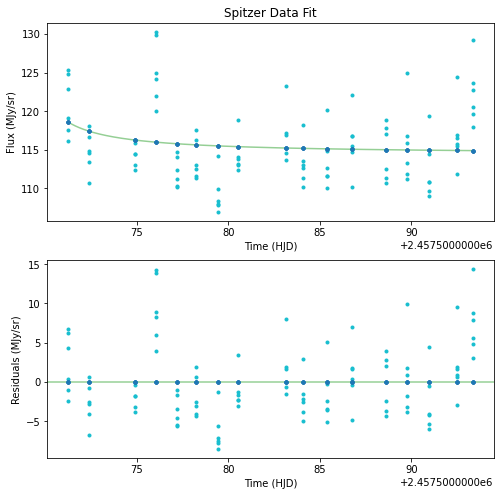

In [46]:
plot_analytic_sol(model,time,popt_lsq,astro,flux,corr)

In [42]:
print(p0)
print(popt_lsq)

[14.79 82.   19.7 ]
[4.86316260e-02 1.14414629e+02 8.67198967e+02]


## MCMC Fit for PLD Parameters

In this section we run a Markov Chain Monte-Carlo (MCMC) fit to our data. This will explore parameter space to optimize the log-likelihood for our model to fit our data. We use the emcee package (https://github.com/dfm/emcee) to do our fit. The log-likelihood function we use is a method of the SingleLensParallaxModel class, as detailed in the 'Spitzer_ulens.models' module.

In [49]:
load_chain_from_file = False
savepath = 'data/ob161195/mcmc/keck'

if load_chain_from_file:
    pos_chain = np.load(os.path.join(savepath,'samplerchain.npy'))
    lnp_chain = np.load(os.path.join(savepath,'samplerlnpro.npy'))
else:
    p0 = popt_lsq
    nwalkers = 100
    nburnin = 300
    nprod = 1000
    
    # Generate the MCMC sampler with 100 walkers, our log-probability function, and our data. We
    # use pool from the multiprocessing package to parallelize the process.
    sampler = emcee.EnsembleSampler(nwalkers, len(p0), model.lnprob, a = 2,
                                    args=(bounds,time,flux,flux_err,flux_frac,
                                          flux_scatter))
    
    # Initialize the initial parameter positions for each walker by adding a random offset. Starting
    # our walkers in different positions allows us to explore more parameter space.
    pos0 = [p0*(1+1e-5*np.random.randn(sampler.ndim))+1e-5*np.abs(np.random.randn(sampler.ndim)) 
            for i in range(sampler.nwalkers)]
    
    # Run the first MCMC burn-in.
    pos1,prob,state = run_mcmc(sampler,pos0,nburnin,label='first burn-in')
    sampler.reset()

    #Run the MCMC from best spot from last time, and do another burn-in to get the walkers spread out.
    pos2 = pos1[np.argmax(prob)]
    
    # Slightly change position of walkers to prevent them from taking the same path
    pos2 = [pos2*(1+1e-6*np.random.randn(sampler.ndim))+1e-6*np.abs(np.random.randn(sampler.ndim)) 
            for i in range(sampler.nwalkers)]
    
    # Run the second burn-in
    pos2, prob, state = run_mcmc(sampler,pos2,nburnin,label='second burn-in')
    sampler.reset()
    
    #Run the final production run that will be saved
    pos_final, prob, state = run_mcmc(sampler,pos2,nprod,label='production')

    pos_chain = sampler.chain
    lnp_chain = sampler.lnprobability
    
    np.save(savepath+'/samplerchain.npy',pos_chain)
    np.save(savepath+'/samplerlnpro.npy',lnp_chain)
    
# Get results from chain
popt_mcmc,pmax,std_hi,std_lo = get_MCMC_results(pos_chain,lnp_chain)

Running MCMC first burn-in...


100%|█████████████████████████████████████████| 300/300 [00:50<00:00,  5.96it/s]


Mean burn-in acceptance fraction: 0.497
MCMC runtime = 0.84 min

Running MCMC second burn-in...


100%|█████████████████████████████████████████| 300/300 [00:49<00:00,  6.08it/s]


Mean burn-in acceptance fraction: 0.519
MCMC runtime = 0.82 min

Running MCMC production...


100%|███████████████████████████████████████| 1000/1000 [02:33<00:00,  6.52it/s]

Mean burn-in acceptance fraction: 0.262
MCMC runtime = 2.56 min



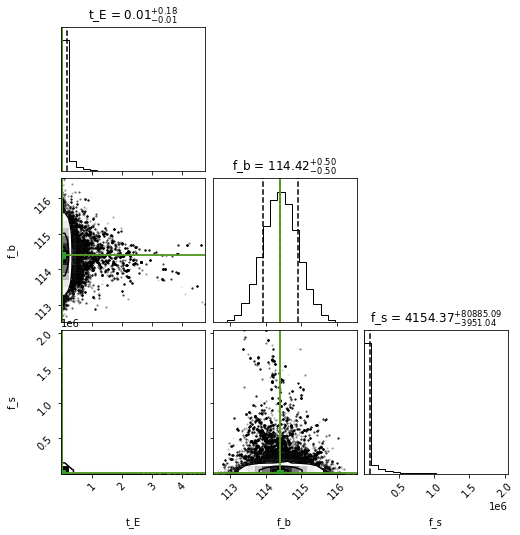

In [54]:
# Create corner plots to check for convergence
# 1d array of samples
samples = pos_chain.reshape((-1, len(popt_mcmc)))

# corner plot
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, plot_datapoints=True, 
                    title_kwargs={"fontsize": 12},labels=plabels)

corner.overplot_lines(fig, popt_mcmc, color="C1", label='Mean parameter position')
corner.overplot_points(fig, popt_mcmc[None], marker="s", color="C1")
corner.overplot_lines(fig, pmax, color="C2", label='Most likely parameter position')
corner.overplot_points(fig, pmax[None], marker="s", color="C2")

#plt.legend(loc=(-5,7),fontsize=16)

In [53]:
# Re-run MCMC if it does not look converged. This cell can be run repeatedly.
rerun_mcmc = True
if rerun_mcmc:
    nwalkers = 100
    nprod = 3000
    
    sampler = emcee.EnsembleSampler(nwalkers, len(p0), model.lnprob, a = 2,
                                    args=(bounds,time,flux,flux_err,flux_frac,
                                          flux_scatter))
    pos0 = pos_chain[:,-1,:]

    pos_final,prob_final,state_final = run_mcmc(sampler,pos0,nprod,label='production')

    pos_chain = sampler.chain
    lnp_chain = sampler.lnprobability
    
    popt_mcmc,pmax,std_hi,std_lo = get_MCMC_results(pos_chain,lnp_chain)
    
    np.save(savepath+'/samplerchain.npy',pos_chain)
    np.save(savepath+'/samplerlnpro.npy',lnp_chain)

Running MCMC production...


100%|███████████████████████████████████████| 3000/3000 [07:11<00:00,  6.95it/s]


Mean burn-in acceptance fraction: 0.177
MCMC runtime = 7.20 min



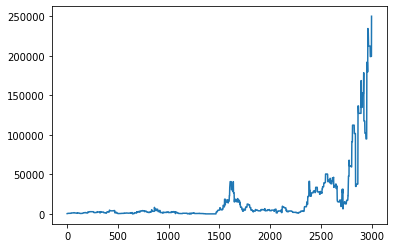

In [55]:
plt.plot(np.mean(pos_chain,axis=2)[1,:])

In [56]:
# Reporting best-fit parameters
def pretty_print(popt,pmax,std_hi,std_lo,labels):
    tab = np.transpose([labels,popt,pmax,std_hi,std_lo])
    print('\t%s\t\t%s\t%s\t\t%s'%('Mean Parameter','Most Likely Parameter',r'Upper 1 sigma',r'Lower 1 sigma'))
    for row in tab:
        print('%s\t%s\t%s\t%s\t%s'%(row[0],row[1],row[2],row[3],row[4]))
pretty_print(popt_mcmc,pmax,std_hi,std_lo,plabels)

	Mean Parameter		Most Likely Parameter	Upper 1 sigma		Lower 1 sigma
t_E	0.009845673012309882	0.0065558297014348356	0.17624639254987803	0.009376642942179672
f_b	114.41955527392425	114.41349663191123	0.5019576426285965	0.5029316877286618
f_s	4154.3693346076025	6435.074348268682	80885.09299379928	3951.04341704436


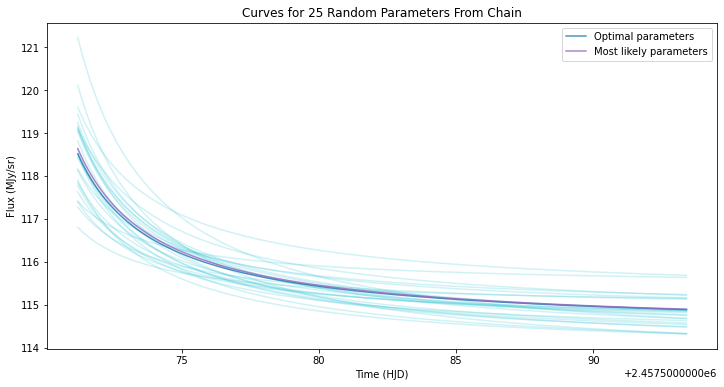

In [57]:
def plot_random_curves(pos_chain,model,timeplot,popt=None,pmax=None,ncurves=1,seed=None,figsize=(8,4)):
    fig,ax = plt.subplots(figsize=figsize)
    nwalkers,nsteps,npars = np.shape(pos_chain)
    chain = pos_chain.reshape(nwalkers*nsteps,-1)
    for i in range(ncurves):
        pars = random.choice(chain)
        ax.plot(timeplot,model(timeplot,*pars),alpha=0.2,c='C9')
    ax.set_title('Curves for %i Random Parameters From Chain'%ncurves)
    ax.set_xlabel('Time (HJD)')
    ax.set_ylabel('Flux (MJy/sr)')
    if popt is not None:
        ax.plot(timeplot,model(timeplot,*popt),alpha=0.8,c='C0',label='Optimal parameters')
    if pmax is not None:
        ax.plot(timeplot,model(timeplot,*pmax),alpha=0.8,c='C4',label='Most likely parameters')
    ax.legend()
        
plot_random_curves(pos_chain,model,timeplot,popt=popt_mcmc,pmax=pmax,ncurves=25,figsize=(12,6))

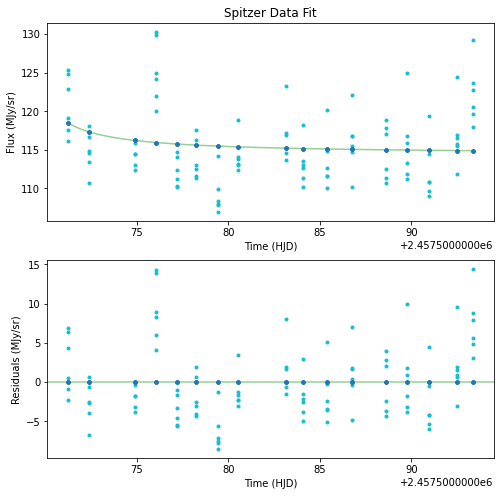

In [58]:
# Final analytic solution for corrected data
astro, pld_coeffs, A, C = PLD.analytic_solution(time,flux,flux_err,flux_frac,popt_mcmc,model)
# Get detector model and divide it out to get new best-fit
fit,sys,corr,resi = PLD.get_bestfit(pld_coeffs, flux, flux_frac, astro, A)
plot_analytic_sol(model,time,popt_mcmc,astro,flux,corr)